# Artificial Neural Networks (CS-456)
## Miniproject 1: Tic Tac Toe
- Mickaël Achkar (322190)
- Yehya El Hassan (325932)


In [378]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
from typing import Dict, List
import hashlib
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [379]:
class RlAgent():
    def __init__(self,player:str,epsilon:float,learning_rate:float = 0.05,discount_factor:float = 0.99):
        # Choose the Player (X,O)
        self.player = player

        # Choose the exploration/exploitation factor
        self.epsilon = epsilon


        # RL training hyper params
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor

        # Form the the q_table and initialize it to empty
        self.q_table:Dict[str,np.ndarray] = {}

        # Actions take values between 0 and 9 representing the possible positions on the board
        self.list_of_possible_actions:List[int] = [] 

        # Initialize the current reward
        self.reward = 0

    def initialize_board(self,board: np.ndarray):
        # Initailize the board
        self._update_board(board)
        self._update_list_of_possible_actions()
        
    def environment_info(self, board, reward):
        # Recieves information from the environment
        self._update_board(board)
        self._update_reward(reward)
        self._update_list_of_possible_actions()

    def act(self, board: np.ndarray):
        # Sample from a uniform distribution
        current_state = get_state_from_board(board)
        if (epsilon>random.uniform(0,1)):
            return self._choose_random_action()
        else:
            return self._choose_best_action(current_state)

    def update_q_table(self,current_state, current_action, next_state, next_action):
        # update the q_table
        current_state = get_state_from_board(current_state)
        next_state = get_state_from_board(next_state)

        # create new entries if needed
        self._create_new_state_entries_if_needed(current_state)
        self._create_new_state_entries_if_needed(next_state)
        
        self.q_table[current_state][current_action] = self.q_table[current_state][current_action] + self.learning_rate*(self.reward + self.discount_factor*(self.q_table[next_state][next_action]) - self.q_table[current_state][current_action])


    def _update_board(self,board):
        # Get's the latest board configuration from the Game
        self.board = board
    
    def _update_list_of_possible_actions(self):
        # Get's the available positions on the board
        avail = []
        for i in range(9):
            pos = (int(i/3), i % 3)
            if self.board[pos] == 0:
                avail.append(i)
        self.list_of_possible_actions = avail
        return self.list_of_possible_actions

    def _update_reward(self, reward):
        # Updates the current reward
        self.reward = reward

    def _choose_best_action(self, current_state):
        self._create_new_state_entries_if_needed(current_state)
        maximum_q_values = np.where(self.q_table[current_state][self.list_of_possible_actions] == np.max(self.q_table[current_state][self.list_of_possible_actions]))[0]
        random_between_max = np.random.choice(maximum_q_values)
        return (self.list_of_possible_actions[random_between_max])

    def _choose_random_action(self):
        return np.random.choice(self.list_of_possible_actions)

    def _create_new_state_entries_if_needed(self, state):
        if (not isinstance(self.q_table.get(state), np.ndarray)):
            self.q_table[state] = np.zeros(9)



def get_state_from_board(board):
     # Convert the Board configuration (Matrix) into a unique key for the state
    return hashlib.sha1(board).hexdigest()

def logger(winner, player_1, player_2):
    # Logs the information if specified
    print('-------------------------------------------')
    print(f'Game end, winner is player {str(winner)}')
    print(f'Optimal player 1 = {str(player_1)}')
    print(f'RL Agent player 2 = {str(player_2)}')
    
def choose_players(index):
    if index%2 == 0:
        player_1 = 'X'
        player_2 = 'O'
    else:
        player_1 = 'O'
        player_2 = 'X' 
        
    return player_1,player_2   


    

Implementing a Tic Tac Toc Player using Q-learning. With that, we will create a Q-table representing all the states and actions possible and we will progressively update the values in the table.

In [380]:
def train_rl_agent(environment: TictactoeEnv,number_of_episodes: int, optimal_level : float, epsilon:float, verbose: bool = False):
    # Initialize the number of RL wins
    number_of_rl_wins = 0

    # Initialize the Rewards
    num_of_reward = int(number_of_episodes/50)
    rewards = np.zeros(num_of_reward)
    reward_index = 0
    reward = 0

    # Instantiate the Players
    player_optimal = OptimalPlayer(epsilon=optimal_level, player="X")
    player_rl_agent = RlAgent(epsilon=epsilon, player="O")

    
    for index in tqdm(range(number_of_episodes)):
        
        # Reset the Environment
        environment.reset()
        
        #Observe the Environment
        grid, _, _ = environment.observe()

        #Choose the players X,O
        player_1,player_2 = choose_players(index = index)
        player_optimal.player = player_1
        player_rl_agent.player = player_2
        
        # Give RL access to the board
        player_rl_agent.initialize_board(grid)

        # Number of RL movements 
        number_of_rl_movements = 0
        
        for step in range(9):
            if environment.current_player == player_optimal.player:
                move = player_optimal.act(grid)
            else:
                if (number_of_rl_movements%2 ==0):
                    rl_current_action = player_rl_agent.act(grid)
                    rl_current_state = grid
                    move = (int(rl_current_action/3),rl_current_action%3)
                else:
                    rl_next_action = player_rl_agent.act(grid)
                    rl_next_state = grid
                    move = (int(rl_next_action/3),rl_next_action%3)
                    player_rl_agent.update_q_table(rl_current_state, rl_current_action, rl_next_state, rl_next_action)

                number_of_rl_movements+=1

        
            grid, end, winner = environment.step(move, print_grid=False)
            player_rl_agent.environment_info(grid,environment.reward(player_2))
            
            if end:
                reward += environment.reward(player_2)
                #Update with the current state action as the next state as current state TODO: check
                if (number_of_rl_movements%2 ==0):
                    player_rl_agent.update_q_table(rl_current_state, rl_current_action, rl_current_state, rl_current_action)
        
                if winner == player_rl_agent.player:
                    number_of_rl_wins+=1
                if verbose:
                    logger(winner, player_1, player_2)
                    environment.render()
                environment.reset()
                break
        
        if (index%50 == 0):
            rewards[reward_index] = reward
            reward = 0
            reward_index+=1

    if reward_index<(num_of_reward)-1:
        rewards[(num_of_reward)-1] = reward

    return player_rl_agent, rewards   




In [381]:
# RL Hyper-params
number_of_episodes = 20000
epsilon = 0.4

environment = TictactoeEnv()

player_rl_agent, rewards = train_rl_agent(environment, number_of_episodes=number_of_episodes, optimal_level=1.0,epsilon=epsilon)

100%|██████████| 20000/20000 [00:40<00:00, 496.65it/s]


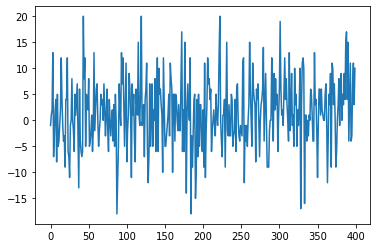

In [382]:
plt.plot(rewards)